In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import shutil
from PIL import Image, ImageEnhance

print("Setting up the environment...")

Setting up the environment...


In [2]:
# File paths setup
meta_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
images_dir1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
images_dir2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'
output_root = '/kaggle/working/balanced_dataset'
img_out = os.path.join(output_root, 'images')
meta_out = os.path.join(output_root, 'balanced_metadata.csv')

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
# Load metadata
print("Loading metadata...")
meta = pd.read_csv(meta_path)

Loading metadata...


In [5]:
# Function to get full path for each image
def full_path(image_id):
    fn = image_id + '.jpg'
    p1 = os.path.join(images_dir1, fn)
    p2 = os.path.join(images_dir2, fn)
    return p1 if os.path.exists(p1) else p2

meta['filepath'] = meta['image_id'].apply(full_path)

Original dataset class distribution:
akiec: 327
bcc: 514
bkl: 1099
df: 115
mel: 1113
nv: 6705
vasc: 142


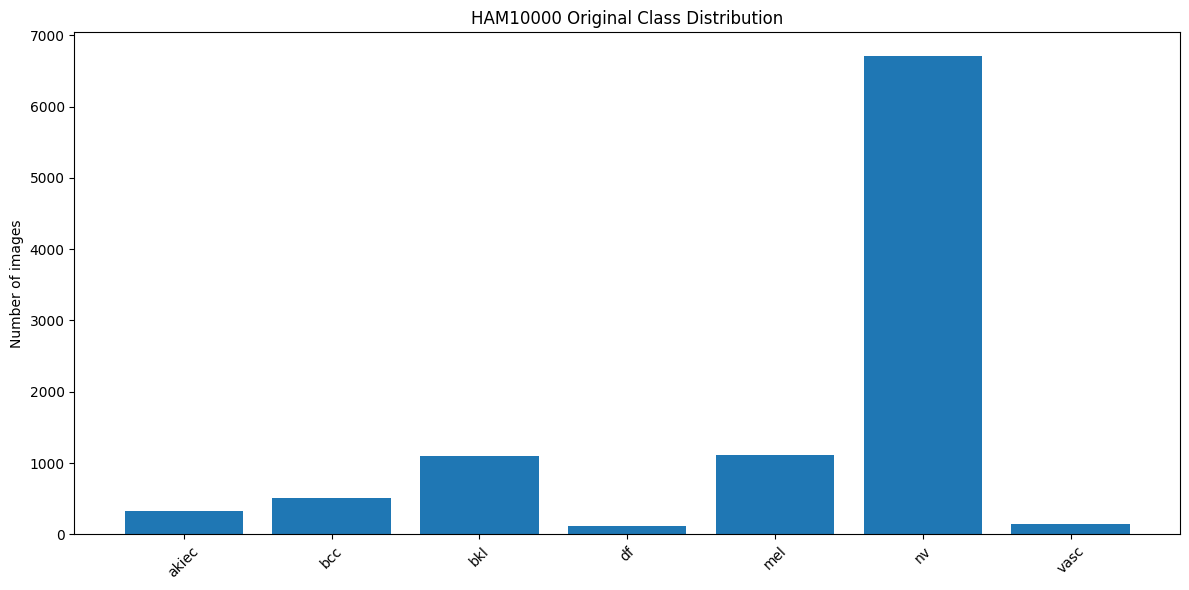

In [6]:
# Display class distribution
class_names = sorted(meta['dx'].unique())
counts = meta['dx'].value_counts().loc[class_names]

print("Original dataset class distribution:")
for cls, cnt in counts.items():
    print(f"{cls}: {cnt}")

plt.figure(figsize=(12, 6))
plt.bar(class_names, counts)
plt.xticks(rotation=45)
plt.ylabel('Number of images')
plt.title('HAM10000 Original Class Distribution')
plt.tight_layout()
plt.show()

In [7]:
# Data balancing with augmentation
print("Balancing dataset...")
os.makedirs(img_out, exist_ok=True)

def find_path(image_id):
    fn = f"{image_id}.jpg"
    p = os.path.join(images_dir1, fn)
    return p if os.path.exists(p) else os.path.join(images_dir2, fn)

def augment(img):
    img = img.rotate(random.uniform(-30, 30))
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(random.uniform(0.7, 1.3))

Balancing dataset...


In [8]:
# Create balanced dataset (2000 images per class)
new_rows = []
for dx, grp in meta.groupby('dx'):
    ids = grp['image_id'].tolist()
    chosen = random.sample(ids, min(len(ids), 2000))

    for iid in chosen:
        src = find_path(iid)
        dst = os.path.join(img_out, f"{iid}.jpg")
        shutil.copy(src, dst)
        new_rows.append(grp[grp['image_id']==iid].iloc[0].to_dict())

    while sum(1 for r in new_rows if r['dx']==dx) < 2000:
        iid = random.choice(ids)
        src = find_path(iid)
        with Image.open(src) as im:
            aug = augment(im)
            aug_id = f"aug_{iid}_{random.randint(0,1000000)}"
            aug.save(os.path.join(img_out, f"{aug_id}.jpg"))
        row = grp[grp['image_id']==iid].iloc[0].to_dict()
        row['image_id'] = aug_id
        new_rows.append(row)

meta_bal = pd.DataFrame(new_rows)
meta_bal.to_csv(meta_out, index=False)

print("\nBalanced dataset complete!")
print(f" • Images → {img_out}")
print(f" • Metadata → {meta_out}")


Balanced dataset complete!
 • Images → /kaggle/working/balanced_dataset/images
 • Metadata → /kaggle/working/balanced_dataset/balanced_metadata.csv


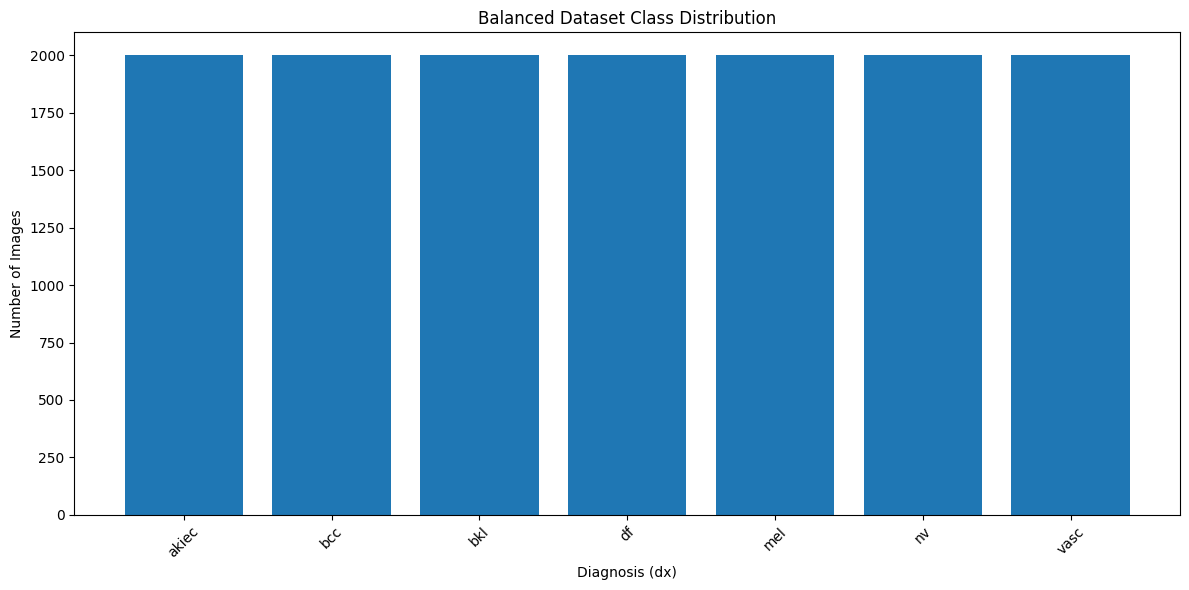

In [9]:
# Check balanced dataset distribution
counts_bal = meta_bal['dx'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(counts_bal.index, counts_bal.values)
plt.title('Balanced Dataset Class Distribution')
plt.xlabel('Diagnosis (dx)')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.paths = df['image_id'].apply(lambda x: os.path.join(img_dir, f"{x}.jpg")).values
        self.labels = df['label_idx'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [11]:
# Label encoding
print("Preparing datasets...")
le = LabelEncoder()
meta_bal['label_idx'] = le.fit_transform(meta_bal['dx'])
num_classes = len(le.classes_)
class_mapping = dict(zip(range(num_classes), le.classes_))
print("\nClass mapping:")
for idx, name in class_mapping.items():
    print(f"{idx}: {name}")

Preparing datasets...

Class mapping:
0: akiec
1: bcc
2: bkl
3: df
4: mel
5: nv
6: vasc


In [12]:
# Split data
train_df, test_df = train_test_split(meta_bal, stratify=meta_bal['label_idx'], test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['label_idx'], test_size=0.1111, random_state=42)

print(f"\nDataset split: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")


Dataset split: Train=9955, Validation=1245, Test=2800


In [13]:
# Transforms
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Datasets and Dataloaders
BATCH_SIZE = 32
train_ds = SkinCancerDataset(train_df, img_out, transform)
val_ds = SkinCancerDataset(val_df, img_out, transform)
test_ds = SkinCancerDataset(test_df, img_out, transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [15]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


Using device: cuda


In [16]:
# Define ResNet50 model
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        model = models.resnet50(weights=None)
        self.features = nn.Sequential(*list(model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(model.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [17]:
# Define MobileNetV3 model
class MobileNetV3Model(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV3Model, self).__init__()
        model = models.mobilenet_v3_large(weights=None)
        self.features = model.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(model.classifier[3].in_features, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [18]:
# Define EfficientNetB0 model
class EfficientNetB0Model(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB0Model, self).__init__()
        model = models.efficientnet_b0(weights=None)
        self.features = model.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(model.classifier[1].in_features, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [19]:
# Factory function to create models
def make_model(model_name):
    if model_name == 'resnet50':
        return ResNet50Model(num_classes).to(device)
    elif model_name == 'mobilenet_v3':
        return MobileNetV3Model(num_classes).to(device)
    elif model_name == 'efficientnet_b0':
        return EfficientNetB0Model(num_classes).to(device)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

In [20]:
# Training and evaluation functions
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    start_time = time.time()
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

           # Compute training accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        # Print progress every 20 batches
        if (i + 1) % 20 == 0:
            print(f"Epoch {epoch+1} | Batch {i+1}/{len(loader)} | Loss: {loss.item():.4f}")
    
    epoch_time = time.time() - start_time
    accuracy = correct/total
    return total_loss / len(loader), epoch_time, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    
    # ✅ Return labels for confusion matrix
    return val_loss / len(loader), accuracy, y_true, y_pred


def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)
            y_probs.extend(probs)
            y_pred.extend(preds)
            y_true.extend(labels.numpy())
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }
    
    # Calculate AUC
    try:
        one_hot = np.zeros((len(y_true), num_classes))
        for i, val in enumerate(y_true):
            one_hot[i, val] = 1
        metrics['auc'] = roc_auc_score(one_hot, np.array(y_probs), average='weighted', multi_class='ovr')
    except Exception as e:
        print(f"Warning: Could not calculate AUC: {e}")
        metrics['auc'] = 0.0
        
    return metrics, y_true, y_pred, y_probs

In [21]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [22]:
# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for model_name, hist in history.items():
        plt.plot(hist['train_loss'], label=f"{model_name} - Train")
        plt.plot(hist['val_loss'], label=f"{model_name} - Val")
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for model_name, hist in history.items():
        plt.plot(hist['val_acc'], label=model_name)
        plt.plot(hist['train_acc'], label=f"{model_name} - Train Acc", linestyle='--')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [23]:
# Dictionary to store results and training history
results = {}
history = {}

In [24]:
# Define model parameters
NUM_EPOCHS = 10
model_names = ['resnet50', 'mobilenet_v3', 'efficientnet_b0']

In [25]:
# Process each model individually
for model_name in model_names:
    print(f"\n{'='*50}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*50}")
    
    # Initialize model
    model = make_model(model_name)
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Initialize history trackers
    history[model_name] = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'epoch_times': [],
        'true_labels': [],
        'pred_labels':[]
    }


Training RESNET50

Training MOBILENET_V3

Training EFFICIENTNET_B0


In [26]:
# Create the three models
print("Creating models...")

# EfficientNet - Fixed for newer torchvision versions
efficientnet_model = models.efficientnet_b0(weights='DEFAULT')
# EfficientNet classifier is a Sequential with the last layer being a Linear layer
num_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_features, num_classes)
)
efficientnet_model = efficientnet_model.to(device)

# ResNet - Fixed for newer torchvision versions
resnet_model = models.resnet18(weights='DEFAULT')
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
resnet_model = resnet_model.to(device)

# Load MobileNetV3 with default pretrained weights
mobilenet_model = models.mobilenet_v3_large(weights='DEFAULT')
# Replace the final classification layer
mobilenet_model.classifier[3] = nn.Linear(mobilenet_model.classifier[3].in_features, num_classes)
# Move the model to the desired device
mobilenet_model = mobilenet_model.to(device)

# Create models dictionary
models_dict = {
    'EfficientNet': efficientnet_model,
    'ResNet': resnet_model,
    'MobileNetV3': mobilenet_model
}

# Initialize history and results for all models
history = {name: {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc': [], 'epoch_times': [], 'true_labels':[], 'pred_labels':[]} for name in models_dict.keys()}
results = {}

print(f"Created models: {list(models_dict.keys())}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Creating models...


100%|██████████| 20.5M/20.5M [00:00<00:00, 143MB/s] 
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 139MB/s] 


Created models: ['EfficientNet', 'ResNet', 'MobileNetV3']


In [27]:
# Training loop for all models
overall_best_acc = 0
overall_best_model = None

# Iterate through all three models
for model_name in models_dict.keys():
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    model = models_dict[model_name]
    
    # Create optimizer for this specific model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    best_val_acc = 0
    
    for epoch in range(NUM_EPOCHS):
        # Train
        train_loss, epoch_time, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
        
        # Validate
        val_loss, val_acc, true_labels, pred_labels = validate(model, val_loader, criterion, device)

        
        # Save History
        history[model_name]['train_loss'].append(train_loss)
        history[model_name]['train_acc'].append(train_acc)
        history[model_name]['val_loss'].append(val_loss)
        history[model_name]['val_acc'].append(val_acc)
        history[model_name]['epoch_times'].append(epoch_time)

        # Only save labels once (after final epoch), OR overwrite each time
        if epoch == NUM_EPOCHS - 1: # only after the final epoch
            history[model_name]['true_labels'] = true_labels
            history[model_name]['pred_labels']= pred_labels
    
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Time: {epoch_time:.2f}s - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
        
        # Save best model for this specific model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"/kaggle/working/{model_name}_best.pth")
            print(f"Model saved with validation accuracy: {val_acc:.4f}")
            
            # Check if this is the overall best model across all models
            if val_acc > overall_best_acc:
                overall_best_acc = val_acc
                overall_best_model = model_name
                torch.save(model.state_dict(), f"/kaggle/working/overall_best_model.pth")
                print(f"NEW OVERALL BEST MODEL: {model_name} with accuracy {val_acc:.4f}")
    
    # Load best model for evaluation
    model.load_state_dict(torch.load(f"/kaggle/working/{model_name}_best.pth"))
    
    # Final evaluation for current model
    print(f"\nFinal evaluation of {model_name} on test set:")
    metrics, y_true, y_pred, *_ = evaluate(model, test_loader, device)
    
    # Save results for current model


Training EfficientNet
Epoch 1 | Batch 20/312 | Loss: 0.9396
Epoch 1 | Batch 40/312 | Loss: 0.6431
Epoch 1 | Batch 60/312 | Loss: 1.1641
Epoch 1 | Batch 80/312 | Loss: 0.5537
Epoch 1 | Batch 100/312 | Loss: 0.6293
Epoch 1 | Batch 120/312 | Loss: 0.6856
Epoch 1 | Batch 140/312 | Loss: 0.5374
Epoch 1 | Batch 160/312 | Loss: 0.9423
Epoch 1 | Batch 180/312 | Loss: 0.7908
Epoch 1 | Batch 200/312 | Loss: 0.3949
Epoch 1 | Batch 220/312 | Loss: 0.7129
Epoch 1 | Batch 240/312 | Loss: 0.5497
Epoch 1 | Batch 260/312 | Loss: 0.5329
Epoch 1 | Batch 280/312 | Loss: 0.4213
Epoch 1 | Batch 300/312 | Loss: 0.4012
Epoch 1/10 - Time: 49.51s - Train Loss: 0.7304 - Val Loss: 0.4227 - Val Acc: 0.8329
Model saved with validation accuracy: 0.8329
NEW OVERALL BEST MODEL: EfficientNet with accuracy 0.8329
Epoch 2 | Batch 20/312 | Loss: 0.6441
Epoch 2 | Batch 40/312 | Loss: 0.8788
Epoch 2 | Batch 60/312 | Loss: 0.3403
Epoch 2 | Batch 80/312 | Loss: 0.8247
Epoch 2 | Batch 100/312 | Loss: 0.6354
Epoch 2 | Batch 12

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot history and summary including training accuracy and confusion matrix
def plot_individual_model_histories_and_summary(history):
    for model_name, hist in history.items():
        plt.figure(figsize=(16, 4))

        # Plot Loss
        plt.subplot(1, 3, 1)
        plt.plot(hist['train_loss'], label='Train Loss', color='blue')
        plt.plot(hist['val_loss'], label='Val Loss', color='orange')
        plt.title(f'{model_name.upper()} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot Accuracy
        plt.subplot(1, 3, 2)
        plt.plot(hist['train_acc'], label='Train Accuracy', color='blue')
        plt.plot(hist['val_acc'], label='Val Accuracy', color='green')
        plt.title(f'{model_name.upper()} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Confusion Matrix
        plt.subplot(1, 3, 3)
        cm = confusion_matrix(hist['true_labels'], hist['pred_labels'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name.upper()} - Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        plt.tight_layout()
        plt.show()

    # Comparison table
    summary_data = []
    for model_name, hist in history.items():
        final_train_loss = hist['train_loss'][-1]
        final_val_loss = hist['val_loss'][-1]
        final_val_acc = hist['val_acc'][-1]
        best_val_acc = max(hist['val_acc'])
        total_time = sum(hist['epoch_times'])

        summary_data.append({
            'Model': model_name,
            'Final Train Loss': round(final_train_loss, 4),
            'Final Val Loss': round(final_val_loss, 4),
            'Final Val Acc (%)': round(final_val_acc * 100, 2),
            'Best Val Acc (%)': round(best_val_acc * 100, 2),
            'Total Time (s)': round(total_time, 2)
        })

    df_summary = pd.DataFrame(summary_data)
    print("\n=== Model Comparison Summary ===")
    print(df_summary.to_string(index=False))


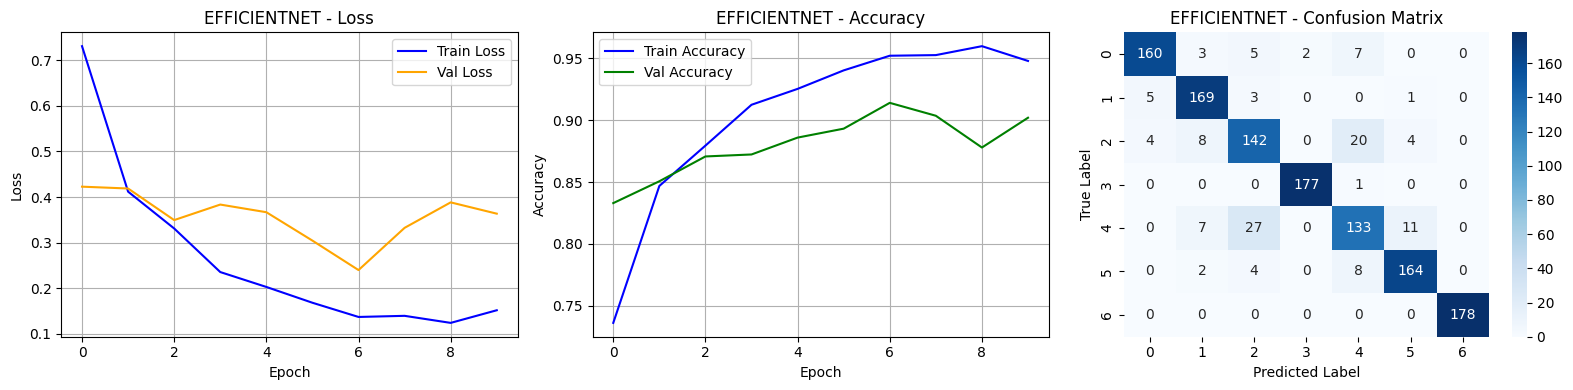

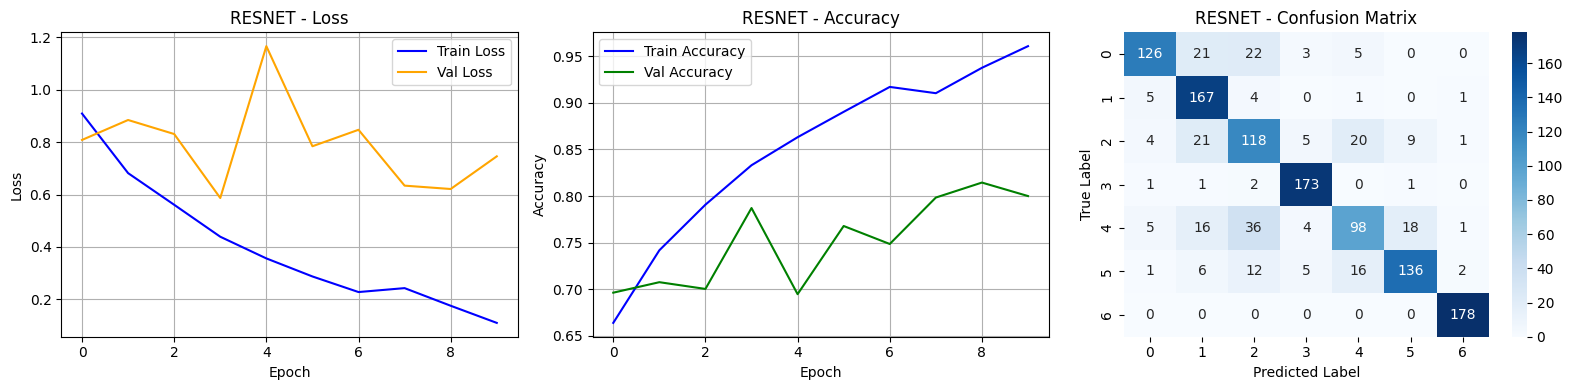

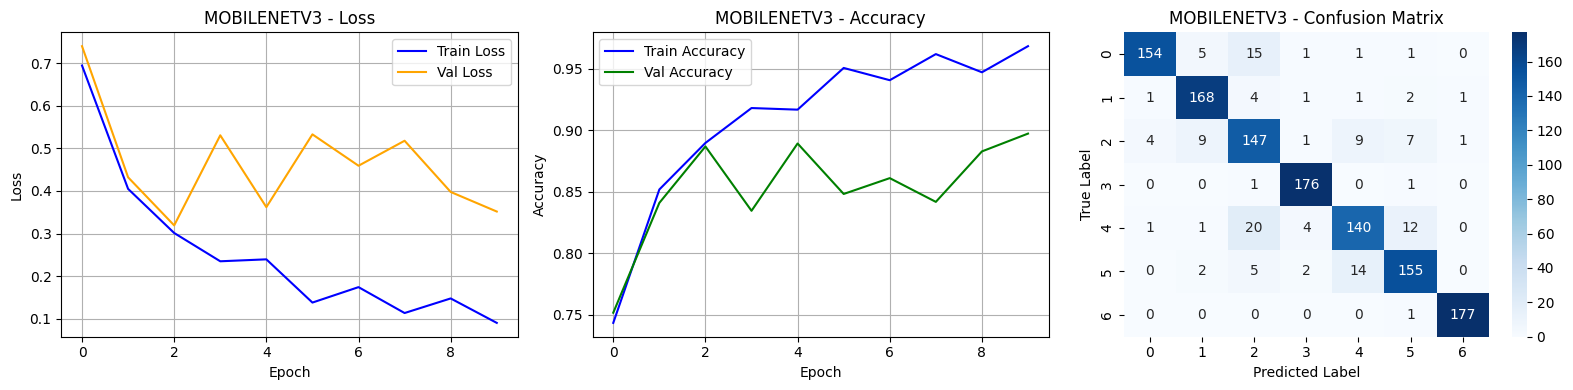


=== Model Comparison Summary ===
       Model  Final Train Loss  Final Val Loss  Final Val Acc (%)  Best Val Acc (%)  Total Time (s)
EfficientNet            0.1519          0.3635              90.20             91.41          502.51
      ResNet            0.1099          0.7457              80.00             81.45          369.02
 MobileNetV3            0.0908          0.3518              89.72             89.72          363.49


In [29]:
plot_individual_model_histories_and_summary(history)